In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
from keras.utils import plot_model
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc, precision_score, accuracy_score, confusion_matrix

In [2]:
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) 

def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation = cv2.INTER_AREA)

In [3]:
disease_types=['positive', 'negative']
data_dir = '/content/Covid'
train_dir = os.path.join(data_dir)

In [4]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])      
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [5]:
IMAGE_SIZE = 128
X = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values), total = len(train)):
    image = read_image(file)
    if image is not None:
        X[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X /= 255.        
y = train['DiseaseID'].values
print(X.shape)
print(y.shape)


(1264, 128, 128, 3)
(1264,)


In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 1)

In [7]:
x_train[:2]

array([[[[0.        , 0.        , 0.        ],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.00392157, 0.00392157, 0.00392157],
         [0.        , 0.        , 0.        ],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.        , 0.        , 0.        ],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.00784314, 0.00784314, 0.00784314],
         ...,
         [0.        , 0.        , 0.        ],
         [0.00784314, 0.00784314, 0.00784314],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.0627451 , 0.0627451 , 0.0627451 ]

In [8]:
y[:]

array([0, 0, 0, ..., 1, 1, 1])

In [10]:
np.random.seed(3)

model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))

model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(528, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [12]:
plot_model(model, 
           show_shapes = True, 
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 60)

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 126, 126, 128)     3584      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 61, 61, 256)       295168    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 256)       590080    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 256)      

In [14]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=64, epochs=10,
                    verbose=1,validation_split=0.1)

Epoch 1/10
15/15 [==============================] - 215s 14s/step - loss: 14.9988 - accuracy: 0.7718 - val_loss: 0.6163 - val_accuracy: 0.8333
Epoch 2/10
15/15 [==============================] - 205s 14s/step - loss: 0.5737 - accuracy: 0.7869 - val_loss: 0.3765 - val_accuracy: 0.8333
Epoch 3/10
15/15 [==============================] - 207s 14s/step - loss: 0.2748 - accuracy: 0.8012 - val_loss: 0.1477 - val_accuracy: 0.9510
Epoch 4/10
15/15 [==============================] - 207s 14s/step - loss: 0.2535 - accuracy: 0.9390 - val_loss: 0.7261 - val_accuracy: 0.6667
Epoch 5/10
15/15 [==============================] - 205s 14s/step - loss: 0.4093 - accuracy: 0.8475 - val_loss: 0.1327 - val_accuracy: 0.9804
Epoch 6/10
15/15 [==============================] - 204s 14s/step - loss: 0.1317 - accuracy: 0.9645 - val_loss: 0.0434 - val_accuracy: 0.9902
Epoch 7/10
15/15 [==============================] - 204s 14s/step - loss: 0.1039 - accuracy: 0.9656 - val_loss: 0.0220 - val_accuracy: 0.9902
Epoch

In [15]:
y_pred = model.predict_classes(x_test)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [16]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

    
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [17]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()


In [18]:
sp = tn/(tn+fp)
sn = tp/(tp+fn)

print('f1 score =  %.3f'%f1_score(y_test, y_pred))
print('Precision =  %.3f'%precision_score(y_test, y_pred))
print('Test accuracy =  %.3f'%accuracy_score(y_test, y_pred))
print('Specificity =  %.3f'%sp)
print('Sensitivity =  %.3f'%sn)

f1 score =  0.995
Precision =  0.995
Test accuracy =  0.992
Specificity =  0.981
Sensitivity =  0.995


In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=64, epochs=5,
                    verbose=1,validation_split=0.1)

Epoch 1/5
15/15 [==============================] - 216s 14s/step - loss: 0.1307 - accuracy: 0.9724 - val_loss: 0.0178 - val_accuracy: 1.0000
Epoch 2/5
15/15 [==============================] - 205s 14s/step - loss: 0.0589 - accuracy: 0.9811 - val_loss: 0.0205 - val_accuracy: 0.9902
Epoch 3/5
15/15 [==============================] - 204s 14s/step - loss: 0.0232 - accuracy: 0.9922 - val_loss: 0.0089 - val_accuracy: 1.0000
Epoch 4/5
15/15 [==============================] - 204s 14s/step - loss: 0.0088 - accuracy: 0.9991 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 5/5
15/15 [==============================] - 204s 14s/step - loss: 0.0047 - accuracy: 0.9984 - val_loss: 0.0491 - val_accuracy: 0.9804


In [20]:
y_pred = model.predict_classes(x_test)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


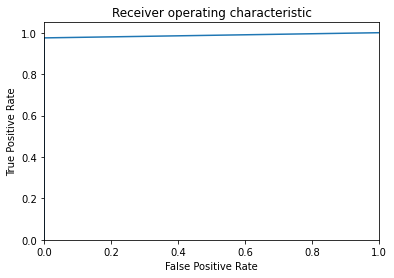

In [21]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

    
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [22]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=64, epochs=5,
                    verbose=1,validation_split=0.1)

Epoch 1/5
15/15 [==============================] - 207s 14s/step - loss: 0.0251 - accuracy: 0.9924 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 2/5
15/15 [==============================] - 205s 14s/step - loss: 0.0031 - accuracy: 0.9997 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 3/5
15/15 [==============================] - 213s 14s/step - loss: 0.0034 - accuracy: 0.9997 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 4/5
15/15 [==============================] - 204s 14s/step - loss: 0.0046 - accuracy: 0.9992 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 5/5
15/15 [==============================] - 204s 14s/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 0.0026 - val_accuracy: 1.0000


In [23]:
y_pred = model.predict_classes(x_test)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


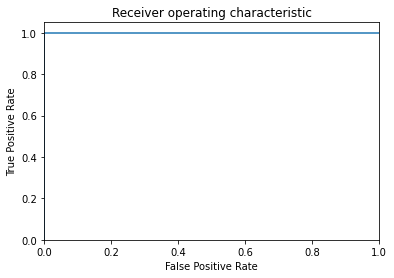

In [24]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

    
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()
#plt.show()

In [26]:
model.save('my_model.h5')
